<a href="https://colab.research.google.com/github/MichaelPaulukonis/notebooks/blob/main/SwinIR_upscaling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SwinIR Online Demo 

[![arXiv](https://img.shields.io/badge/arXiv-Paper-<COLOR>.svg)](https://arxiv.org/abs/2108.10257)
[![GitHub Stars](https://img.shields.io/github/stars/JingyunLiang/SwinIR?style=social)](https://github.com/JingyunLiang/SwinIR)
[![download](https://img.shields.io/github/downloads/JingyunLiang/SwinIR/total.svg)](https://github.com/JingyunLiang/SwinIR/releases)

This is a modified notebook of the original. I am hoping to use it to batch-process images w/o the cruft of comparison versions.

This is a **SwinIR online demo on Real-World Image SR** of our paper [''SwinIR: Image Restoration Using Swin Transformer''](https://arxiv.org/abs/2108.10257). 

SwinIR achieves state-of-the-art performance on six tasks: image super-resolution (including classical, lightweight and real-world image super-resolution), image denoising (including grayscale and color image denoising) and JPEG compression artifact reduction. See our [paper](https://arxiv.org/abs/2108.10257) and [project page](https://github.com/JingyunLiang/SwinIR) for detailed results. In particular, we train the real-world image SR model by using **the first practical degradation model [BSRGAN, ICCV2021](https://github.com/cszn/BSRGAN)**. We also refer to a recent model [Real-ESRGAN](https://arxiv.org/abs/2107.10833) for better loss function.

<img src="https://raw.githubusercontent.com/JingyunLiang/SwinIR/main/figs/real_world_image_sr.png" width="100%">



In [ ]:
#@title Save to Google Drive
#@markdown Will periodically save your results to Google Drive under the folder [TBD]

save_to_google_drive = True  #@param {type: "boolean"}
download_zipfile = True  #@param {type: "boolean"}


if save_to_google_drive:
  from google.colab import drive
  import time
  
  #@title Google Colab Google Drive Downloader Thing { vertical-output: true }
  Target_Folder = "/content/drive/MyDrive/colab_out/upscaled/" #@param {type:"string"}

  batch_prefix = "babies" #@param {type:"string"}
  Target_Folder += batch_prefix + "/"

  drive.mount('/content/drive')
  
  !mkdir -p $Target_Folder

Mounted at /content/drive


# 1. Preparations
Before start, make sure that you choose
* Runtime Type = Python 3
* Hardware Accelerator = GPU
* Broswer != Firefox (cannot upload images in step 2)

in the **Runtime** menu -> **Change runtime type**

Then, we clone the repository, set up the envrironment, and download the pre-trained model.

In [ ]:
# Clone realESRGAN
!git clone https://github.com/xinntao/Real-ESRGAN.git
%cd Real-ESRGAN
# Set up the environment
!pip install basicsr
!pip install facexlib
!pip install gfpgan
!pip install -r requirements.txt
!python setup.py develop

# Clone BSRGAN
!git clone https://github.com/cszn/BSRGAN.git

!rm -r SwinIR
# Clone SwinIR
!git clone https://github.com/JingyunLiang/SwinIR.git
!pip install timm

# Download the pre-trained models
!wget https://github.com/cszn/KAIR/releases/download/v1.0/BSRGAN.pth -P BSRGAN/model_zoo
!wget https://github.com/xinntao/Real-ESRGAN/releases/download/v0.1.0/RealESRGAN_x4plus.pth -P experiments/pretrained_models
!wget https://github.com/JingyunLiang/SwinIR/releases/download/v0.0/003_realSR_BSRGAN_DFO_s64w8_SwinIR-M_x4_GAN.pth -P experiments/pretrained_models
!wget https://github.com/JingyunLiang/SwinIR/releases/download/v0.0/003_realSR_BSRGAN_DFOWMFC_s64w8_SwinIR-L_x4_GAN.pth -P experiments/pretrained_models

Cloning into 'Real-ESRGAN'...
remote: Enumerating objects: 682, done.
remote: Counting objects: 100% (17/17), done.
remote: Compressing objects: 100% (16/16), done.
remote: Total 682 (delta 4), reused 11 (delta 1), pack-reused 665
Receiving objects: 100% (682/682), 5.03 MiB | 4.44 MiB/s, done.
Resolving deltas: 100% (359/359), done.
/content/Real-ESRGAN
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 171 kB 4.1 MB/s 
     |████████████████████████████████| 5.9 MB 19.5 MB/s 
     |████████████████████████████████| 190 kB 76.5 MB/s 
  Created wheel for basicsr: filename=basicsr-1.4.1-py3-none-any.whl size=213765 sha256=8052f3033aae35cf0921a7641484e0add4f98e33c92e97e5f0567c9d51d901bb
  Stored in directory: /root/.cache/pip/wheels/36/c5/b3/dc9fdd1dc0f95e37ef35144686bfa374cb81985a38a8539ba0
Successfully built basicsr
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/p

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
running develop
running egg_info
creating realesrgan.egg-info
writing realesrgan.egg-info/PKG-INFO
writing dependency_links to realesrgan.egg-info/dependency_links.txt
writing requirements to realesrgan.egg-info/requires.txt
writing top-level names to realesrgan.egg-info/top_level.txt
writing manifest file 'realesrgan.egg-info/SOURCES.txt'
reading manifest template 'MANIFEST.in'
adding license file 'LICENSE'
writing manifest file 'realesrgan.egg-info/SOURCES.txt'
running build_ext
Creating /usr/local/lib/python3.7/dist-packages/realesrgan.egg-link (link to .)
Adding realesrgan 0.2.5.0 to easy-install.pth file

Installed /content/Real-ESRGAN
Processing dependencies for realesrgan==0.2.5.0
Searching for tqdm==4.64.0
Best match: tqdm 4.64.0
Adding tqdm 4.64.0 to easy-install.pth file
Installing tqdm script to /usr/local/bin

Using /usr/local/lib/python3.7/dist-packages
Searching for torchvis

# 2. Upload Images

Upload the images to be processed by SwinIR

In [ ]:
import os
import glob
from google.colab import files
import shutil
print(' Note1: You can find an image on the web or download images from the RealSRSet (proposed in BSRGAN, ICCV2021) at https://github.com/JingyunLiang/SwinIR/releases/download/v0.0/RealSRSet+5images.zip.\n Note2: You may need Chrome to enable file uploading!\n Note3: If out-of-memory, set test_patch_wise = True.\n')

# test SwinIR by partioning the image into patches
test_patch_wise = False

# to be compatible with BSRGAN
!rm -r BSRGAN/testsets/RealSRSet
upload_folder = 'BSRGAN/testsets/RealSRSet'
result_folder = 'results'

if os.path.isdir(upload_folder):
    shutil.rmtree(upload_folder)
if os.path.isdir(result_folder):
    shutil.rmtree(result_folder)
os.mkdir(upload_folder)
os.mkdir(result_folder)

# upload images
uploaded = files.upload()
for filename in uploaded.keys():
  dst_path = os.path.join(upload_folder, filename)
  print(f'move {filename} to {dst_path}')
  shutil.move(filename, dst_path)

 Note1: You can find an image on the web or download images from the RealSRSet (proposed in BSRGAN, ICCV2021) at https://github.com/JingyunLiang/SwinIR/releases/download/v0.0/RealSRSet+5images.zip.
 Note2: You may need Chrome to enable file uploading!
 Note3: If out-of-memory, set test_patch_wise = True.



Saving 386.png to 386.png
Saving 385.png to 385.png
Saving 384.png to 384.png
Saving 383.png to 383.png
Saving 382.png to 382.png
Saving 381.png to 381.png
Saving 380.png to 380.png
Saving 379.png to 379.png
Saving 378.png to 378.png
Saving 377.png to 377.png
Saving 376.png to 376.png
Saving 375.png to 375.png
Saving 374.png to 374.png
Saving 373.png to 373.png
Saving 372.png to 372.png
Saving 371.png to 371.png
Saving 370.png to 370.png
Saving 369.png to 369.png
Saving 368.png to 368.png
Saving 367.png to 367.png
Saving 366.png to 366.png
Saving 365.png to 365.png
Saving 364.png to 364.png
Saving 363.png to 363.png
Saving 362.png to 362.png
Saving 361.png to 361.png
Saving 360.png to 360.png
Saving 359.png to 359.png
Saving 358.png to 358.png
Saving 357.png to 357.png
Saving 356.png to 356.png
Saving 355.png to 355.png
Saving 354.png to 354.png
Saving 353.png to 353.png
Saving 352.png to 352.png
Saving 351.png to 351.png
Saving 350.png to 350.png
Saving 349.png to 349.png
Saving 348.p

# 3. Inference


In [ ]:
# SwinIR
if test_patch_wise:
  !python SwinIR/main_test_swinir.py --task real_sr --model_path experiments/pretrained_models/003_realSR_BSRGAN_DFO_s64w8_SwinIR-M_x4_GAN.pth --folder_lq BSRGAN/testsets/RealSRSet --scale 4 --tile 800
else:
  !python SwinIR/main_test_swinir.py --task real_sr --model_path experiments/pretrained_models/003_realSR_BSRGAN_DFO_s64w8_SwinIR-M_x4_GAN.pth --folder_lq BSRGAN/testsets/RealSRSet --scale 4
shutil.move('results/swinir_real_sr_x4', 'results/SwinIR')

# # SwinIR-Large
# if test_patch_wise:
#   !python SwinIR/main_test_swinir.py --task real_sr --model_path experiments/pretrained_models/003_realSR_BSRGAN_DFOWMFC_s64w8_SwinIR-L_x4_GAN.pth --folder_lq BSRGAN/testsets/RealSRSet --scale 4 --large_model --tile 640
# else:
#   !python SwinIR/main_test_swinir.py --task real_sr --model_path experiments/pretrained_models/003_realSR_BSRGAN_DFOWMFC_s64w8_SwinIR-L_x4_GAN.pth --folder_lq BSRGAN/testsets/RealSRSet --scale 4 --large_model
# shutil.move('results/swinir_real_sr_x4_large', 'results/SwinIR_large')

# for path in sorted(glob.glob(os.path.join('results/SwinIR_large', '*.png'))):
#   os.rename(path, path.replace('SwinIR.png', 'SwinIR_large.png')) # here is a bug in Colab file downloading: no same-name files

loading model from experiments/pretrained_models/003_realSR_BSRGAN_DFO_s64w8_SwinIR-M_x4_GAN.pth
/usr/local/lib/python3.7/dist-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2894.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
Testing 0 000                 
Testing 1 001                 
Testing 2 002                 
Testing 3 003                 
Testing 4 004                 
Testing 5 005                 
Testing 6 006                 
Testing 7 007                 
Testing 8 008                 
Testing 9 009                 
Testing 10 010                 
Testing 11 011                 
Testing 12 012                 
Testing 13 013                 
Testing 14 014                 
Testing 15 015                 
Testing 16 016                 
Testing 17 017                 
Testing 18 018           

'results/SwinIR'

# 4. Visualization

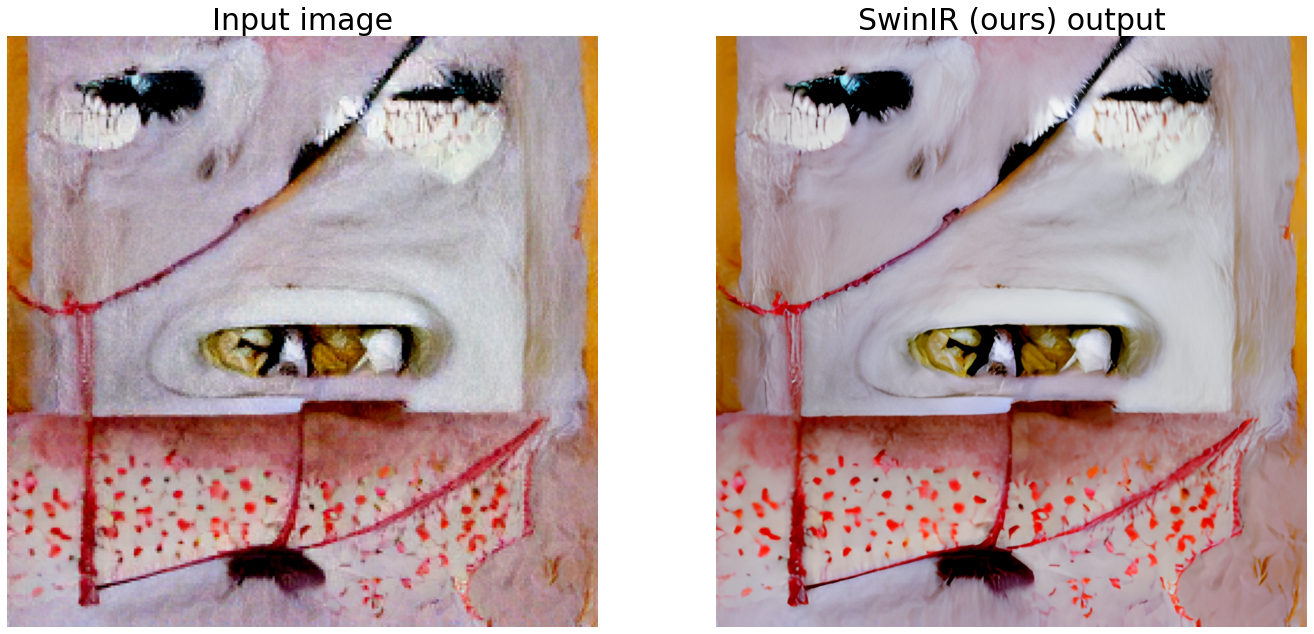

In [ ]:
# utils for visualization
import cv2
import matplotlib.pyplot as plt

def display(img1, img2):
  total_figs = 3
  fig = plt.figure(figsize=(total_figs*12, 14))
  ax1 = fig.add_subplot(1, total_figs, 1) 
  plt.title('Input image', fontsize=30)
  ax1.axis('off')

  ax2 = fig.add_subplot(1, total_figs, 2)
  plt.title('SwinIR (ours) output', fontsize=30)
  ax2.axis('off')

  ax1.imshow(img1)
  ax2.imshow(img2['SwinIR'])

def imread(img_path):
  img = cv2.imread(img_path)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  return img

# display first image in the upload folder
input_folder = upload_folder
result_folder = 'results/SwinIR'
input_list = sorted(glob.glob(os.path.join(input_folder, '*')))
output_list = sorted(glob.glob(os.path.join(result_folder, '*')))
# for input_path, output_path in zip(input_list, output_list):
input_path = input_list[0]
output_path = output_list[0]

img_input = imread(input_path)
img_output = {}
img_output['SwinIR'] = imread(output_path)

display(img_input, img_output)

# 5. Download Results


In [ ]:
# Download and/or Save the results
if save_to_google_drive:

  for output_path in output_list:
    outname = output_path.replace('results/SwinIR/', Target_Folder)
    # print(output_path, outname)
    print(f"copying to {outname}")
    os.system(f"cp {output_path} {outname}")

if download_zipfile:

  zip_filename = 'SwinIR_result.zip'
  if os.path.exists(zip_filename):
    os.remove(zip_filename)
  os.system(f"zip -r -j {zip_filename} results/*")
  files.download(zip_filename)

copying to /content/drive/MyDrive/colab_out/upscaled/babies/000_SwinIR.png
copying to /content/drive/MyDrive/colab_out/upscaled/babies/001_SwinIR.png
copying to /content/drive/MyDrive/colab_out/upscaled/babies/002_SwinIR.png
copying to /content/drive/MyDrive/colab_out/upscaled/babies/003_SwinIR.png
copying to /content/drive/MyDrive/colab_out/upscaled/babies/004_SwinIR.png
copying to /content/drive/MyDrive/colab_out/upscaled/babies/005_SwinIR.png
copying to /content/drive/MyDrive/colab_out/upscaled/babies/006_SwinIR.png
copying to /content/drive/MyDrive/colab_out/upscaled/babies/007_SwinIR.png
copying to /content/drive/MyDrive/colab_out/upscaled/babies/008_SwinIR.png
copying to /content/drive/MyDrive/colab_out/upscaled/babies/009_SwinIR.png
copying to /content/drive/MyDrive/colab_out/upscaled/babies/010_SwinIR.png
copying to /content/drive/MyDrive/colab_out/upscaled/babies/011_SwinIR.png
copying to /content/drive/MyDrive/colab_out/upscaled/babies/012_SwinIR.png
copying to /content/drive

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>